# Project Update
### 2019-03-19

## Calculating thermal time indices and merging UAV data.

**Name**: Byron Evers<br/>
**Semester**: Spring 2019 <br/>
**Project area**: Agronomy

**Objective:** 

Write a python function to calculate biometeorological time (BMT), physiological days (Pdays) and growing degree days (GDD) for several UAV collection dates. The objective is to have the thermal time parameters calculated for the specific dates that UAV data was collected. Ultimitly, through a python function, I would like merge all of the UAV reflectance data, plot level phenotypic data and the calculated thermal values into one .csv file.

**Rational:** 
Current phenotyping methods are labor intensive, hard to replicate, and have limited temporal resolution. UAVs equipped with multispectral sensors present a possible solution to obtain valuable time sensitive data. To use these data points in spatio-temporal models, crop phenology needs to be estimate. Past research papers have used a range of thermal time equations to estimate crop phenology (Saiyed et al 2009). However, there is still a need to compare evaluate these thermal predictors in relationship to reflectance data.

Over the last two growing season I have collected UAV reflectance data across several breeding nursery locations at several dates. Currently this data is being merged with plot level data with excel. This process is inefficient and introduces potential errors. I would like to stream line this process with Python. Additionally, having the ability to calculate several phenological development thermal times, with a Python function, will be useful for modeling purposes.

Current UAV pipeline includes stitching photos and extracting plot level reflectance data through Agisoft software. Data recived from this process is formated as a .csv file and includes 5 indiviual reflectance bands (R,G,B,RE and NIR) and 3 vegitative indices (NDVI, NDRE and GNDVI). Each band and vegitative index can be be used to analyze biophysical traits of various crops. At this time I do not wish to calculate these indcies with python, though I would like to write a python script that can combine the Agisoft data with the calculated thermal times and plot level data such as yield and plant hieght.

**Step: 1 Download data from the KSU Mesonet**
- Go to http://mesonet.k-state.edu/weather/historical/
- Select location of intrest. For this projcet I have started with the Scandia weather station.
- Enter the range of dates you would like to download. However, maximum range is 366 days. For this project I have dowloaded days for the 2016-2017 winter wheat growing season. I used dates ranging from 2016-09-01 to 2017-07-15. This is beyond the scope of the growing season but the defined function will only capture the dates within the growing season. 
- Export the data as a CSV to your working directory 


**Step: 2 import needed modules**

In [152]:
import pandas as pd
import numpy as np
import glob
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
%matplotlib inline

**Step3: Review equation and evaluate minimum needed variables.**
- Review equation and evaluate minimum needed variables.    
**Growing Degree Days (GDD)**:
$$GDD = \sum_{Planting}^{Harvest}(\frac{Tmax+Tmin}{2})-Tbase$$
**Physological Days (Pdays)**:
$$Pdays = \frac{1}{24}(5*P(T_1)+8*P(T_2)+8*P(T_3)+3*P(T_4))$$
**Where**
$$T_1=Tmin$$

$$$$

$$T_2=\frac{(2*Tmin)+Tmax}{3}$$

$$$$

$$T_3=\frac{Tmin+(2*Tmax)}{3}$$

$$$$

$$T_4=Tmax$$

**And P is**
$$P=0$$   $$when T <=Tmin$$

$$$$

$$P=k*(1-\frac{(T-Topt)2}{(Topt-Tmin)2})$$ $$when Tmin <= T <=Topt$$

$$$$

$$P=k*(1-\frac{(T-Topt)2}{(Tmax-Topt)2})$$ $$when Topt <= T <=Tmax$$

$$$$

$$P=0$$   $$when T >=Tmax$$


**Step4: Import data and review format**
- Set directory name and file name

In [153]:
dirname = '/Users/bevers/Desktop/Coding/Project_Update/'
filename = '2017_growing_season.txt'

- Import file and review the first 10 entries to check content and format

In [154]:
df = pd.read_csv(dirname + filename)
#df.head(10)

<img src="mesonetimport.png" alt="sketch_image" width="500"/>

**Step5: Edit data frame to match format needed**

In [155]:
df.rename(columns={'Timestamp':'Date', 'AirTemperature':'Tmax', 'AirTemperature.1':'Tmin'}, inplace=True)
df = df.drop((df.index[:2])) # Drop top lines of non numaric data
df = df.drop(['RelativeHumidity', 'Precipitation', 'WindSpeed2m','WindSpeed2m.1','SoilTemperature5cm','SoilTemperature5cm.1',
             'SoilTemperature10cm','SoilTemperature10cm.1','SolarRadiation','ETo','ETo.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 2 to 343
Data columns (total 4 columns):
Date       342 non-null object
Station    342 non-null object
Tmax       342 non-null object
Tmin       342 non-null object
dtypes: object(4)
memory usage: 13.4+ KB


**Step6: Edit data types**
- The data should be in a 'pandas.core.frame.DataFrame'
- Date should be in datetime64 format
- Tmax and Tmin should be float64 format

In [156]:
#Set T_max and T_min to float values
df.Tmin = df.Tmin.astype(float)
df.Tmax = df.Tmax.astype(float)

df.Date =  pd.to_datetime(df.Date,format='%Y-%m-%d')
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 2 to 343
Data columns (total 4 columns):
Date       342 non-null datetime64[ns]
Station    342 non-null object
Tmax       342 non-null float64
Tmin       342 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 13.4+ KB


**Step7: Set user inputs**
- Set planting date in 'YYYY-MM-DD' form. Make sure it is a string
- Set harvest date in 'YYYY-MM-DD' form. Make sure it is a string
- Set your base/minimum temperatrue (Tbase) value in degrees C
- Set you optimum temperature (Topt) value in degrees C
- Set you maximum temperature (Tmax) value in degrees C
- Set k scale factor, default is 10

In [157]:
# Define inputs 
plantDate=np.datetime64('2016-10-10') #set the date your crop was planted
harvestDate=np.datetime64('2017-09-10') #set the date your crop was planted
tbase=0 # set the base temperature for your given crop. 
topt=17
tmax=31
k= .5 # scale factor set to a value of 10

**Step 7: Define GDD function**
- Only uses dates between planting and harvesting
- Adds Tbase to the dataframe
- Adds a GDD for each indivudual date
- Adds a running cumlative total (cum_GDD) for GDD throughout the season

In [158]:
#Define function
def GDD(df):
    """
    Clacluates an individual and cumluative value for GDD for each day in the dataframe
    
    Input: Pandas dataframe. Minimum required columns include:
        T_max= daily maximum temprerature
        T_min= daily minimum temperatrue
        Date = date of collection
        
    Output: Pandas dataframe. In addition the columns in the dataframe input two additional columns will be clclulated and added:
        GDD= The growing degree day value for that individual day
        cum_GDD = The cumlative growing degree day value for all days in the designated growing period.
    
    Byron Evers
    
    2019-03-06
    """
    df = df.drop(df[df.Date < plantDate].index)
    df = df.drop(df[df.Date > harvestDate].index)
    df['Tbase']=tbase
    df['tavg'] =((df.Tmax+df.Tmin)/2)
    values = np.where(df.tavg < tbase, df.Tbase, df.tavg).astype(float)
    df['GDD']=(values)-df.Tbase
    df['cum_GDD'] = df.GDD.cumsum()
    return df

**Step 8: Define Pdays function**
- Only uses dates between planting and harvesting
- Adds a Pday for each indivudual date
- Adds a running cumlative total (cum_Pdays) for Pdays throughout the season

In [159]:
def Pdays(df):
    df = df.drop(df[df.Date < plantDate].index)
    df = df.drop(df[df.Date > harvestDate].index)
    T1=np.where(df.Tmin > tbase, df.Tmin, 0)
    T4=np.where(df.Tmax > 30, 30, df.Tmax)
    T2=((2*T1) + T4)/2
    T3=((2*T4) + T1)/2
    T =((df.Tmax+df.Tmin)/2)
    df['P'] = np.where(T < topt,(k*(1-((T-topt)*2)/((topt-df.Tmin)*2))),99)
    df['P'] = np.where(T > topt,(k*(1-((T-topt)*2)/((df.Tmax-topt)*2))),df.P)
    df['P'] = np.where(T < tbase,0,df.P)
    df['P'] = np.where(T > tmax,0,df.P)
    df['Pdays']= (1/24)*((5*df.P*T1)+ (8*df.P*T2) + (8*df.P*T3) + (3*df.P*T4))
    df['cum_Pdays']= df.Pdays.cumsum()
    return df

**Step 9: Call the function and store as a varable**
- Call the first 5 items of the data frame to make sure the function worked properly


In [160]:
df = GDD(df)
df =Pdays(df)
df.head(5)
df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 41 to 343
Data columns (total 11 columns):
Date         303 non-null datetime64[ns]
Station      303 non-null object
Tmax         303 non-null float64
Tmin         303 non-null float64
Tbase        303 non-null int64
tavg         303 non-null float64
GDD          303 non-null float64
cum_GDD      303 non-null float64
P            303 non-null float64
Pdays        303 non-null float64
cum_Pdays    303 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 28.4+ KB


**Step 10: Plot cumlative**
- Gives visualization to GDD as a tool to ensure the cumlative value never decreases. If it does decrease then either the inputs or the function needs to be adjusted.
- This can also be used to compare other thermal perameters (Pdays and BMT) as these functions are added and defined. 

In [161]:
#df.set_index('Date', inplace=True)

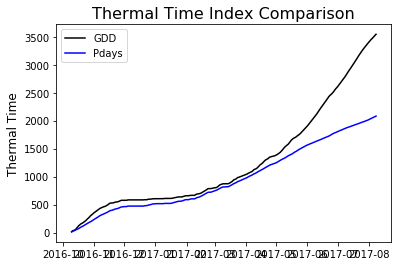

In [162]:
#df.cum_GDD.plot(title='2017-2018 Cumlative GDD')
#df.set_index(df.Date, inplace=True)
plt.plot(df.Date, df.cum_GDD, 'k')
plt.plot(df.Date, df.cum_Pdays, 'b')
plt.title('Thermal Time Index Comparison', size=16)
plt.ylabel('Thermal Time', size=12)
plt.legend(['GDD','Pdays'])
plt.show()